#### Dealing with imblanced dataset

In this case, we will use undersampling to reduce the dominant data (<=50K) as long as the ratio is 50:50

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from imblearn.under_sampling import RandomUnderSampler

In [3]:
df = pd.read_csv('processed.csv')

In [4]:
y = df['income'] # target
X = df.drop(columns='income') # all features

In [5]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [6]:
print(X_resampled.shape)
print(y_resampled.shape)

(15016, 97)
(15016,)


To confirm our dataset is balance, we plot a pie chart for illustration

([<matplotlib.patches.Wedge at 0x20b556efac0>,
 [Text(6.735557395310444e-17, 1.1, '1'),
  Text(-2.0206672185931328e-16, -1.1, '0')],
 [Text(3.6739403974420595e-17, 0.6, '50.0%'),
  Text(-1.1021821192326178e-16, -0.6, '50.0%')])

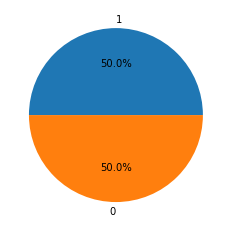

In [7]:
plt.pie(y_resampled.value_counts(),labels=y_resampled.value_counts().index,autopct='%1.1f%%')

### 4. Model Training

In this section, the followings will be done:
- Train-test Split

For the classification model, we will use machine learning algorithms listed as follows:
- Logistic Regression
- Random Forest
- XGBoost

To evaluate their performance, we will focus on the precision score and try to minimum the false positive

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#### Train-test split

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=41)
print('Train data stroke count')
display(y_train.value_counts())
print('Test data stroke count')
display(y_val.value_counts())

Train data stroke count


0    5287
1    5224
Name: income, dtype: int64

Test data stroke count


1    2284
0    2221
Name: income, dtype: int64

#### Logistic Regression

In [10]:
# GridSearchCV
log_clf = Pipeline([
#    ( 'column-onehot', col_trans ),
    ( 'classifier', LogisticRegression() )
])
hyperparams = { 
    'classifier__C': np.linspace(0.0001, 0.01, 50),
    'classifier__max_iter': range(80, 111)
}

log_search = GridSearchCV(log_clf,  hyperparams, n_jobs = -1,cv=5, verbose=1)
log_search.fit(X_train, y_train)
y_pred = log_search.predict(X_val)
print("Best params", log_search.best_params_)
print("Best score", log_search.best_score_)
log_C = log_search.best_params_['classifier__C']
log_max_iter = log_search.best_params_['classifier__max_iter']


Fitting 5 folds for each of 1550 candidates, totalling 7750 fits
Best params {'classifier__C': 0.007373469387755103, 'classifier__max_iter': 87}
Best score 0.7161001478111328


#### Random Forest

In [11]:
forest_clf = Pipeline([
    ( 'classifier', RandomForestClassifier() )
])
hyperparams = { 
    'classifier__n_estimators': [int(x) for x in np.linspace(start=50, stop=150, num=20)],
    'classifier__max_depth': [int(x) for x in np.linspace(40, 100, num=20)],

}

forest_search = GridSearchCV(forest_clf,  hyperparams, n_jobs = -1,cv=5,verbose=1)
forest_search.fit(X_train, y_train)
y_pred = forest_search.predict(X_val)
print("Best params", forest_search.best_params_)
print("Best score", forest_search.best_score_)
forest_n_estimators = forest_search.best_params_['classifier__n_estimators']
forest_max_depth = forest_search.best_params_['classifier__max_depth']

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best params {'classifier__max_depth': 49, 'classifier__n_estimators': 134}
Best score 0.8246603443135243


#### XGBoost

In [12]:
import xgboost as xgb

In [13]:
xgb_clf = Pipeline([
    ( 'classifier', xgb.XGBClassifier(
        booster='gbtree',
        learning_rate=0.3,
        base_score=0.5,
        colsample_bylevel=1, 
        colsample_bytree=1, 
        gamma=0,
        reg_alpha=0,
        random_state=40
        
    ) 
    )
])
hyperparams = { 
    'classifier__n_estimators': np.arange(500,800,50),
    'classifier__max_depth':[2,6,8,10],
    
}

xgb_search = GridSearchCV(xgb_clf,  hyperparams, n_jobs = -1,cv=5,verbose=2)
xgb_search.fit(X_train, y_train)
y_pred = xgb_search.predict(X_val)
print("Best params", xgb_search.best_params_)
print("Best score", xgb_search.best_score_)
xgb_n_estimators = xgb_search.best_params_['classifier__n_estimators']
xgb_max_depth = xgb_search.best_params_['classifier__max_depth']

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\toddp\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params {'classifier__max_depth': 2, 'classifier__n_estimators': 600}
Best score 0.8335083811672238


In [14]:
algorithm = ['LogisticRegression','RandomForestClassifier','XGBClassifier']
hyperparameters = [
    LogisticRegression(
        C = log_C, 
        max_iter=log_max_iter
    ), 
    RandomForestClassifier(
        n_estimators = forest_n_estimators,
        max_depth = forest_max_depth,
    ),
    xgb.XGBRFClassifier(
        n_estimators = xgb_n_estimators,
        max_depth = xgb_max_depth
    )
]

In [15]:
models=dict(zip(algorithm,hyperparameters))
print(models)

{'LogisticRegression': LogisticRegression(C=0.007373469387755103, max_iter=87), 'RandomForestClassifier': RandomForestClassifier(max_depth=49, n_estimators=134), 'XGBClassifier': XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bytree=None, gamma=None, gpu_id=None,
                importance_type='gain', interaction_constraints=None,
                max_delta_step=None, max_depth=2, min_child_weight=None,
                missing=nan, monotone_constraints=None, n_estimators=600,
                n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', random_state=None, reg_alpha=None,
                scale_pos_weight=None, tree_method=None,
                validate_parameters=None, verbosity=None)}


In [16]:
def draw_roc_curve(false_positive_rate, true_positive_rate, roc_auc):
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive_rate, true_positive_rate, label='Validation = {:.3f})'.format(roc_auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

LogisticRegression 0.7589345172031077




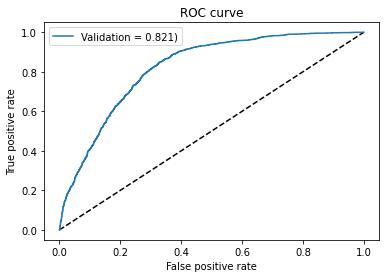

              precision    recall  f1-score   support

           0       0.81      0.66      0.73      2221
           1       0.72      0.85      0.78      2284

    accuracy                           0.76      4505
   macro avg       0.77      0.76      0.76      4505
weighted avg       0.77      0.76      0.76      4505

[1950, 752]
[334, 1469]


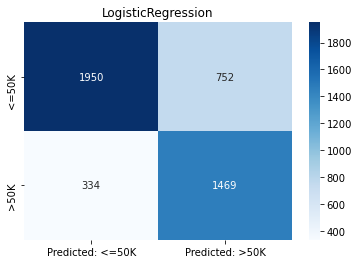

<Figure size 720x360 with 0 Axes>

RandomForestClassifier 0.8270810210876803




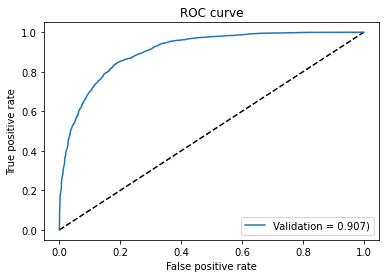

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      2221
           1       0.83      0.83      0.83      2284

    accuracy                           0.83      4505
   macro avg       0.83      0.83      0.83      4505
weighted avg       0.83      0.83      0.83      4505

[1903, 398]
[381, 1823]


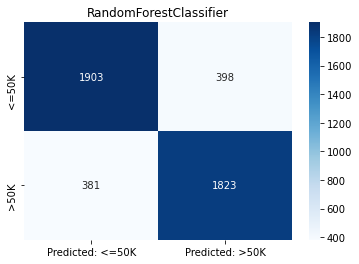

<Figure size 720x360 with 0 Axes>

C:\Users\toddp\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier 0.7782463928967813




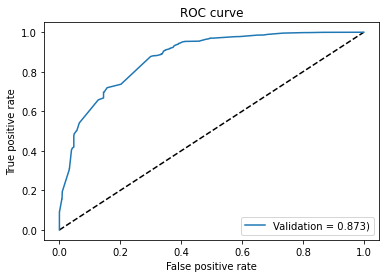

              precision    recall  f1-score   support

           0       0.85      0.67      0.75      2221
           1       0.73      0.89      0.80      2284

    accuracy                           0.78      4505
   macro avg       0.79      0.78      0.77      4505
weighted avg       0.79      0.78      0.78      4505

[2027, 742]
[257, 1479]


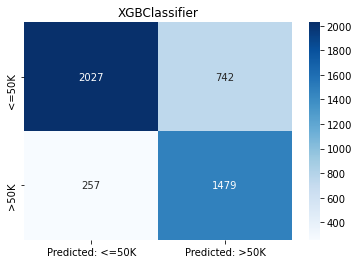

<Figure size 720x360 with 0 Axes>

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
acc_score_list =[]
precision_score_list=[]
for name,algo in models.items():
    model=algo
    # Model Training
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    
    # Accuracy score, precision score
    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    acc_score_list.append(acc)
    precision_score_list.append(precision)
    
    # ROC AUC
    y_prob = model.predict_proba(X_val)[:, 1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    print(name,acc)
    print('\n')
    draw_roc_curve(false_positive_rate, true_positive_rate, roc_auc)
    
    # Confusion Matrix
    print(classification_report(y_val, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    print([tp,fp])
    print([fn,tn])
    ax = plt.axes()
    ax.set_title(name)
    plt.figure(figsize=(10,5))
    cm_data = [tp, fp], [fn, tn]
    conf_matrix = pd.DataFrame(data=cm_data,columns=['Predicted: <=50K','Predicted: >50K'],index=['<=50K','>50K'])
    sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="Blues",ax=ax)
    plt.show()


[0.7589345172031077, 0.8270810210876803, 0.7782463928967813]
[0.7216876387860843, 0.8270317253368101, 0.7320332249909715]


Text(0.5, 1.0, 'Model Precision Score')

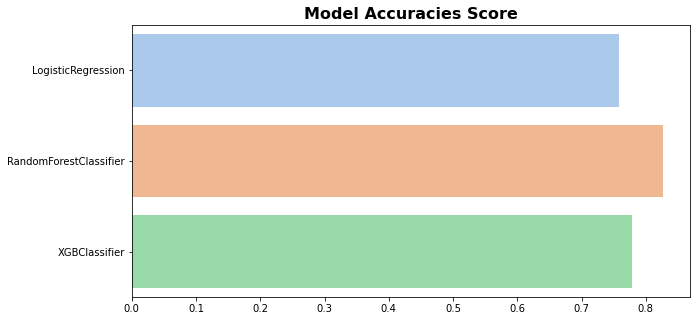

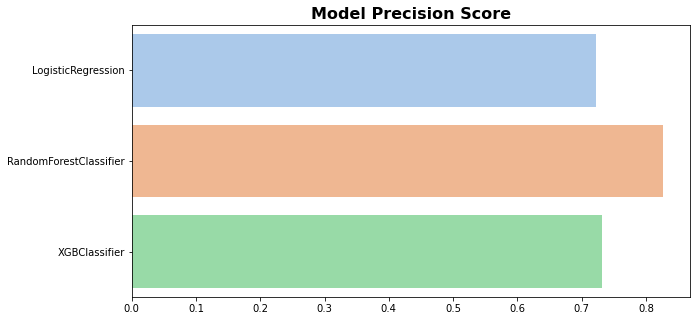

In [18]:
print(acc_score_list)
plt.figure(figsize = (10,5))
sns.barplot(x = acc_score_list, y = algorithm , palette='pastel')
plt.title("Model Accuracies Score", fontsize=16, fontweight="bold")

print(precision_score_list)
plt.figure(figsize = (10,5))
sns.barplot(x = precision_score_list, y = algorithm , palette='pastel')
plt.title("Model Precision Score", fontsize=16, fontweight="bold")